# Goal 
1. ap the attention weights of CodeGen to the characters and visualize a heatmap over the source code.
1. visualize the attention weights layer by layer and apply the post-processing of the paper: “Quantifying Attention Flow In Transformers”, ACL 2020.


In [1]:
import os

import numpy as np
from typing import List, Tuple, Any
import json
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import project_path

import matplotlib as mpl
rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally


from attwizard.decoder import get_attention_tensor
from attwizard.decoder import merge_attention_prompt_and_new_tokens
from attwizard.decoder import get_attention_matrix
from attwizard.decoder import condense_attention
from attwizard.decoder import heatmap_visualize
from attwizard.decoder import normalize_less_attention_on_early_tokens

import torch

In [2]:
%load_ext autoreload
%autoreload 2

## Parameters

In [3]:
MODEL_FOLDER = "/mnt/huggingface_models"
HUGGING_FACE_REPO = "Salesforce/codegen-350M-mono"
FOLDER_WITH_SAMPLES = "code_snippet_samples"

EXP_NAME = "exp_v07"
EXP_FOLDER = os.path.join("..", "data", "model_output", EXP_NAME)

# Query Model (CodeGen 350M)

In [4]:
from transformers import AutoTokenizer
from attwizard.models.modeling_codegen import CodeGenForCausalLM
from attwizard.script.utils import get_model_folder_path

model_folder_path = get_model_folder_path(
    model_folder=MODEL_FOLDER,
    hugging_short_repo=HUGGING_FACE_REPO
)

if os.path.exists(os.path.join(model_folder_path, "pytorch_model.bin")):
    print("Model loaded locally...")
    tokenizer = AutoTokenizer.from_pretrained(model_folder_path)
    model = CodeGenForCausalLM.from_pretrained(model_folder_path)
    print(model)
else:
    print("You must download the model first with: attwizard.script.download_model.py.")

Model loaded locally...


Some weights of the model checkpoint at /mnt/huggingface_models/Salesforce_codegen-350M-mono/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.5.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.0.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.14.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on an

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropo

In [5]:
prompt = """a = 3
b = 5
c = a
d = 7
e = d
f = b
g = a
h = 4 + d
i = d
j = h
print(f) # prints the value '5'
print(g) # prints the value '3'
print(f) # prints the value '5'
print(e) # prints the value '7'
print(c) # prints the value '3'
print(h) # prints the value '11'
print(j) # prints the value '4'
print(i) # prints the value '7'
"""


In [6]:
tmp = tokenizer(prompt, return_tensors="pt")
input_ids = tmp['input_ids']
attention_mask = tmp['attention_mask']
torch.manual_seed(37)  # 42

N_NEW_TOKENS = 20

model_output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    do_sample=True,
    max_time=3,
    eos_token_id=tokenizer.eos_token_id,
    temperature=0.9,
    output_attentions=True,
    max_length=len(input_ids[0]) + N_NEW_TOKENS, 
    return_dict_in_generate=True
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [7]:
generated_text = tokenizer.decode(model_output["sequences"][0])
print(generated_text)

a = 3
b = 5
c = a
d = 7
e = d
f = b
g = a
h = 4 + d
i = d
j = h
print(f) # prints the value '5'
print(g) # prints the value '3'
print(f) # prints the value '5'
print(e) # prints the value '7'
print(c) # prints the value '3'
print(h) # prints the value '11'
print(j) # prints the value '4'
print(i) # prints the value '7'
print(k) # prints the value '1'
print(l) # prints the value


This view aggregates all the layers and heads with a max function


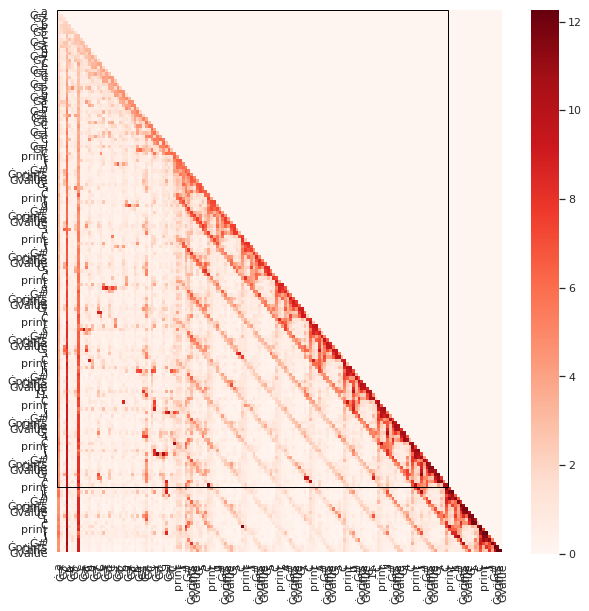

In [9]:
from attwizard.decoder import get_attention_tensor
from attwizard.decoder import merge_attention_prompt_and_new_tokens
from attwizard.decoder import get_attention_matrix
from attwizard.decoder import condense_attention
from attwizard.decoder import heatmap_visualize
from attwizard.decoder import normalize_less_attention_on_early_tokens

import torch

tokens_all_attended = tokenizer.convert_ids_to_tokens(model_output["sequences"][0])
tokens_prompt = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens_generated = tokens_all_attended[len(tokens_prompt):]

att_tensor = get_attention_tensor(
    model_output=model_output
)
att_tensor = normalize_less_attention_on_early_tokens(
    att_tensor=att_tensor
)
condensed_att_tensor = \
    merge_attention_prompt_and_new_tokens(att_tensor)
condensed_att_tensor = \
    condense_attention(
        condensed_att_tensor, 
        reduce_direction="both",
        reduce_function=torch.amax)
att_matrix = get_attention_matrix(
    attention_tensor=condensed_att_tensor)
heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=tokens_all_attended,
    n_input_tokens=len(tokens_prompt)
)
print("This view aggregates all the layers and heads with a max function")

# Follow Up Attention

In [4]:

import typing
from typing import ForwardRef
def get_follow_up_attention_matrix_v1(
        attention_tensor: typing.Union[np.ndarray, ForwardRef('torch.Tensor')]):
    """
    Extract the follow-up attention for a layer and head. 
    Assume that dims are:
    0 is irrelevant (sum over it!)
    1 is layer
    2 isn’t there
    3 is head
    4 is attended from or to
    5 is attended to or from
    """
    assert len(attention_tensor.shape) == 6
    n_layers = attention_tensor.shape[1]
    n_heads = attention_tensor.shape[3]
    n_tokens = attention_tensor.shape[4]
    assert n_tokens == attention_tensor.shape[5], "to and from dimension mismatch"
    attention_tensor = attention_tensor.sum(2).sum(0)
    output = np.zeros((n_tokens, n_tokens, n_layers - 1))
    for k_layer in range(n_layers - 1):
        for i_first_attended in range(n_tokens):
            # who attended to it in layer i?
            attend_to_i_in_layer = attention_tensor[k_layer, :, :, i_first_attended].sum(0)
            attend_to_i_in_layer = attend_to_i_in_layer / np.linalg.norm(attend_to_i_in_layer)
            for j_second_attended in range(n_tokens):
                # who attended to it in layer i+1?
                attend_to_j_in_next_layer = attention_tensor[k_layer + 1, :, :, j_second_attended].sum(0)
                attend_to_j_in_next_layer = attend_to_j_in_next_layer / np.linalg.norm(attend_to_j_in_next_layer)
                # take the dot product of the two
                output[i_first_attended, j_second_attended, k_layer] = \
                    np.dot(attend_to_i_in_layer, attend_to_j_in_next_layer)
    return output

In [5]:

import typing
from typing import ForwardRef
def get_follow_up_attention_matrix_v2(
        attention_tensor: typing.Union[np.ndarray, ForwardRef('torch.Tensor')],
        normalise: bool = True, minus_mean = False):
    """
    Extract the follow-up attention for a layer and head. 
    Assume that dims are:
    0 is irrelevant (sum over it!)
    1 is layer
    2 isn’t there
    3 is head
    4 is attended from or to
    5 is attended to or from
    """
    assert len(attention_tensor.shape) == 6
    n_layers = attention_tensor.shape[1]
    n_heads = attention_tensor.shape[3]
    n_tokens = attention_tensor.shape[4]
    assert n_tokens == attention_tensor.shape[5], "to and from dimension mismatch"
    attention_tensor = attention_tensor.sum(2).sum(0)  # sum over the heads
    output = np.zeros((n_tokens, n_tokens, n_layers - 1))
    for k_layer in range(n_layers - 1):
        layer_matrix = attention_tensor[k_layer, :, :, :].sum(0)
        next_layer_matrix = attention_tensor[k_layer + 1, :, :, :].sum(0)
        # make it so each recipient has sum of attention = 1
        for i in range(n_tokens):
            layer_matrix[i, :] = layer_matrix[i, :] / layer_matrix[i, ].sum()
            next_layer_matrix[i, :] = next_layer_matrix[i, :] / next_layer_matrix[i, ].sum()
        for i_first_attended in range(n_tokens):
            for j_second_attended in range(n_tokens):
                # only tokens after i and j can be compared:
                max_i_j = max(i_first_attended, j_second_attended)
                # who attended to it in layer k?
                attend_to_i_in_layer = attention_tensor[k_layer, :, max_i_j:, i_first_attended].sum(0)
                # who attended to it in layer k+1?
                attend_to_j_in_next_layer = attention_tensor[k_layer + 1, :, max_i_j:, j_second_attended].sum(0)
                if minus_mean:
                    attend_to_i_in_layer = attend_to_i_in_layer - torch.mean(attend_to_i_in_layer)
                    attend_to_j_in_next_layer = attend_to_j_in_next_layer - torch.mean(attend_to_j_in_next_layer)
                if normalise:
                    attend_to_i_in_layer = attend_to_i_in_layer / np.linalg.norm(attend_to_i_in_layer)
                    attend_to_j_in_next_layer = attend_to_j_in_next_layer / np.linalg.norm(attend_to_j_in_next_layer)
                # take the dot product of the two
                dotproduct = np.dot(attend_to_i_in_layer, attend_to_j_in_next_layer)
                output[i_first_attended, j_second_attended, k_layer] = \
                    0 if np.isnan(dotproduct) else dotproduct
    return output

In [6]:
import typing
from typing import ForwardRef
from scipy.stats import pearsonr   
def get_follow_up_attention_matrix_v3(
        attention_tensor: typing.Union[np.ndarray, ForwardRef('torch.Tensor')]):
    """
    Extract the follow-up attention for a layer and head. 
    Assume that dims are:
    0 is irrelevant (sum over it!)
    1 is layer
    2 isn’t there
    3 is head
    4 is attended from or to
    5 is attended to or from
    """
    assert len(attention_tensor.shape) == 6
    n_layers = attention_tensor.shape[1]
    n_heads = attention_tensor.shape[3]
    n_tokens = attention_tensor.shape[4]
    assert n_tokens == attention_tensor.shape[5], "to and from dimension mismatch"
    attention_tensor = attention_tensor.sum(2).sum(0)
    output = np.zeros((n_tokens, n_tokens, n_layers - 1))
    for k_layer in range(n_layers - 1):
        layer_matrix = attention_tensor[k_layer, :, :, :].sum(0)
        next_layer_matrix = attention_tensor[k_layer + 1, :, :, :].sum(0)
        # make it so each recipient has sum of attention = 1
        for i in range(n_tokens):
            layer_matrix[i, :] = layer_matrix[i, :] / layer_matrix[i, ].sum()
            next_layer_matrix[i, :] = next_layer_matrix[i, :] / next_layer_matrix[i, ].sum()
        for i_first_attended in range(n_tokens):
            for j_second_attended in range(n_tokens):
                # only tokens after i and j can be compared:
                max_i_j = max(i_first_attended, j_second_attended)
                # who attended to it in layer k?
                attend_to_i_in_layer = attention_tensor[k_layer, :, max_i_j:, i_first_attended].sum(0)
                # who attended to it in layer k+1?
                attend_to_j_in_next_layer = attention_tensor[k_layer + 1, :, max_i_j:, j_second_attended].sum(0)
                # compute the correlation between those two vectors
                if len(attend_to_i_in_layer) >= 2:
                    output[i_first_attended, j_second_attended] = \
                        pearsonr(attend_to_i_in_layer.numpy(), attend_to_j_in_next_layer.numpy())[0]
                else:
                    output[i_first_attended, j_second_attended] = 0
    return output

In [13]:
att_matrix_2 = get_follow_up_attention_matrix_v1(att_tensor)
att_matrix_3 = get_follow_up_attention_matrix_v2(att_tensor, normalise=True) # best so far
att_matrix_4 = get_follow_up_attention_matrix_v2(att_tensor, normalise=False)
att_matrix_5 =  get_follow_up_attention_matrix_v2(att_tensor, normalise=True, minus_mean=True)
att_matrix_6 =  get_follow_up_attention_matrix_v3(att_tensor)

In [14]:
def normalize_matrix_by_lines(att_matrix):
    att_matrix[0,:] = 0.0000001
    att_matrix[:,0] = 0.0000001
    for i in range(att_matrix.shape[0]):
        att_matrix[i, :] = att_matrix[i, :] / att_matrix[i, :].sum()
    return att_matrix
att_matrix_2_processed = normalize_matrix_by_lines(att_matrix_2.sum(2))
att_matrix_3_processed = normalize_matrix_by_lines(att_matrix_3.sum(2))
att_matrix_4_processed = normalize_matrix_by_lines(att_matrix_4.sum(2))
att_matrix_5_processed = normalize_matrix_by_lines(att_matrix_5.sum(2))
att_matrix_6_processed = normalize_matrix_by_lines(att_matrix_6.sum(2))


(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

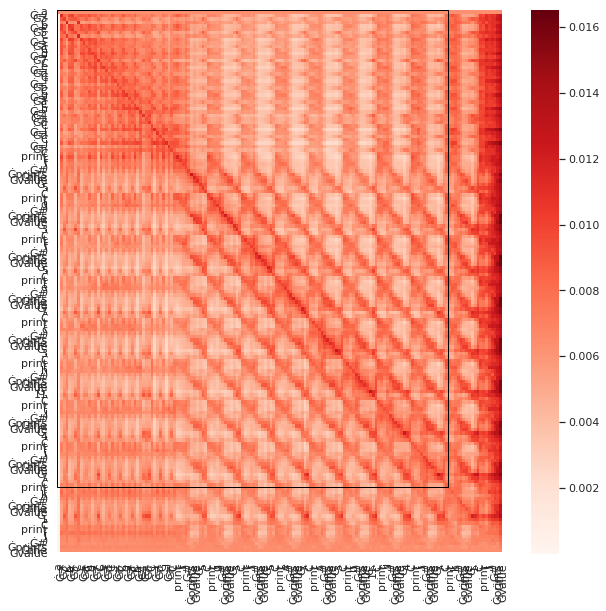

In [15]:
# Visualise those attention maps

heatmap_visualize(
    attention_matrix=att_matrix_3_processed,
    token_names=tokens_all_attended,
    n_input_tokens=len(tokens_prompt)
)

In [16]:
from ipywidgets import interact, IntSlider
from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

def show_att_map_position(token_pos, temporal_matrix=2, temporal=False, hide_generation = True, crispen_attention = True, side_difference = False):
    """Show the attention map of a specific token position."""
    global model_output
    global generated_text
    global tokens_all_attended
    print(f"You see the weights of attention to represent the token: {tokens_all_attended[token_pos]} at position {token_pos}")
    print(f"This token representation is used to predict all the tokens after this.")
    if temporal:
        att_weights = list(temporal_matrices[temporal_matrix][token_pos,:])
    else:
        # extract the weights for that token representation
        att_weights = get_attention_representation(att_matrix, token_pos=token_pos)
        att_weights = list(att_weights.numpy())
    if hide_generation:
        len_prompt = input_ids.shape[1]
        att_weights[len_prompt:] = np.repeat(0, len(att_weights[len_prompt:]))
    if side_difference:
        att_weights_2 = att_weights
        for i in range(att_weights.shape[0]):
            for j in range(att_weights.shape[1]):
                att_weights_2[i, j] = att_weights[i, j] - att_weights[j, i]
        for i in range(att_weights.shape[0]):
            for j in range(att_weights.shape[1]):
                att_weights[i, j] = att_weights_2[i, j] + np.min(att_weights_2)
    if crispen_attention:
        att_weights = [x ** 4 for x in att_weights]
    # append 1 because the last token is unattended, it is simply generated 
    # attending the previous ones.
    att_weights.append(0)
    print(len(att_weights))
    # convert the attntion to char level (easier to compare and display)
    att_weights_gpt_neo_char_level = map_to_char_level(
        tokens=tokens_all_attended,
        att_weights=att_weights,
        raw_text=generated_text,
        #distribution_fn="equal_share",
        distribution_fn="replication",
        special_char_mapping={
            "Ġ": ' ',
            "Ċ": '\n',
        }
    )
    char_tokens = tokenize_char_level(generated_text)
    # display
    python_sc = SourceCode(char_tokens)
    fig, ax = python_sc.show_with_weights(
        weights=att_weights_gpt_neo_char_level,
        show_line_numbers=True,
        char_height=12,
    )
    
gpt_tokens_labels = [
    (t[1], t[0]) for t in list(enumerate(tokens_all_attended))
]

temporal_matrices = [
    att_matrix_2_processed,
    att_matrix_3_processed,
    att_matrix_4_processed,
    np.abs(att_matrix_5_processed),
    att_matrix_6_processed,
]
temp_matrices_slider = IntSlider(min=0, max=len(temporal_matrices)-1, step=1, value=0)
interact(show_att_map_position, token_pos=gpt_tokens_labels, temporal_matrix=temp_matrices_slider)

interactive(children=(Dropdown(description='token_pos', options=(('a', 0), ('Ġ=', 1), ('Ġ3', 2), ('Ċ', 3), ('b…

<function __main__.show_att_map_position(token_pos, temporal_matrix=2, temporal=False, hide_generation=True, crispen_attention=True, side_difference=False)>

Other ideas:

* Zoom into asymmetric attention, i.e. cases where the gaze goes A -> B, but not B -> A -- that is what the "side difference" which isn't implemented yet means.
* Normalise by distance, since closeness matters so much.
* For A -> B observed by Z, let only Z be tokens, but A and B be lines.

# CodeGen on Sense-Making

In [7]:
import torch
from attwizard.script.utils_model import get_model_tokenization
from attwizard.shaper import aggregate_dim_tokens_to_line

## Example 1: Hannoi Q1

In [ ]:
FILE_NAME_TO_INSPECT = "hannoi_Q1.py_Salesforce_codegen-16B-multi"
FILE_PATH_ATT_TENSOR = os.path.join(EXP_FOLDER, FILE_NAME_TO_INSPECT + ".npy")
FILE_PATH_METADATA = os.path.join(EXP_FOLDER, FILE_NAME_TO_INSPECT + ".json")

att_tensor = np.load(FILE_PATH_ATT_TENSOR)
metadata = json.load(open(FILE_PATH_METADATA, 'r'))

# artificially add two useless dimensions
att_tensor = np.expand_dims(att_tensor, axis=0)
att_tensor = np.expand_dims(att_tensor, axis=2)

print(metadata.keys())
print(att_tensor.shape)
print(metadata["text_generated"])

In [44]:
att_matrix_3 = get_follow_up_attention_matrix_v2(att_tensor, normalise=True) # best so far
def normalize_matrix_by_lines(att_matrix):
    att_matrix[0,:] = 0.0000001
    att_matrix[:,0] = 0.0000001
    for i in range(att_matrix.shape[0]):
        att_matrix[i, :] = att_matrix[i, :] / att_matrix[i, :].sum()
    return att_matrix
# sum over the attention heads and normalize
att_matrix_3_processed = normalize_matrix_by_lines(att_matrix_3.sum(2))

In [34]:
# get the tokenization used by the model
codegen_tokenization_4_model = get_model_tokenization(
    raw_text=metadata["text_generated"],
    tokenizer="Salesforce/codegen-16B-multi",
    model_folder=MODEL_FOLDER,
    separate_new_lines_tokens=False,
)

# discard the last token because no-one is attending it
indices = np.array(
        [t['l'] - 1 for t in codegen_tokenization_4_model][:-1]
)

# reconstruct the lines corresponding to this tokenization
lines = []
unique_line_ids = list(set([t['l'] for t in codegen_tokenization_4_model]))
for i in unique_line_ids:
    new_line = "".join([
        t['t'] for t in codegen_tokenization_4_model 
        if t['l'] == i
    ])
    lines.append(new_line)

# condense the token -> token map to a line-> line matrix
line_level_att_tensor = att_matrix_3_processed

line_level_att_tensor = aggregate_dim_tokens_to_line(
    att_tensor=line_level_att_tensor,
    dim=0,
    line_indices=indices,
)
line_level_att_tensor = aggregate_dim_tokens_to_line(
    att_tensor=line_level_att_tensor,
    dim=1,
    line_indices=indices,
)
line_level_att_tensor.shape

(269, 269)
(269,)


(<Figure size 1080x972 with 1 Axes>, <AxesSubplot:>)

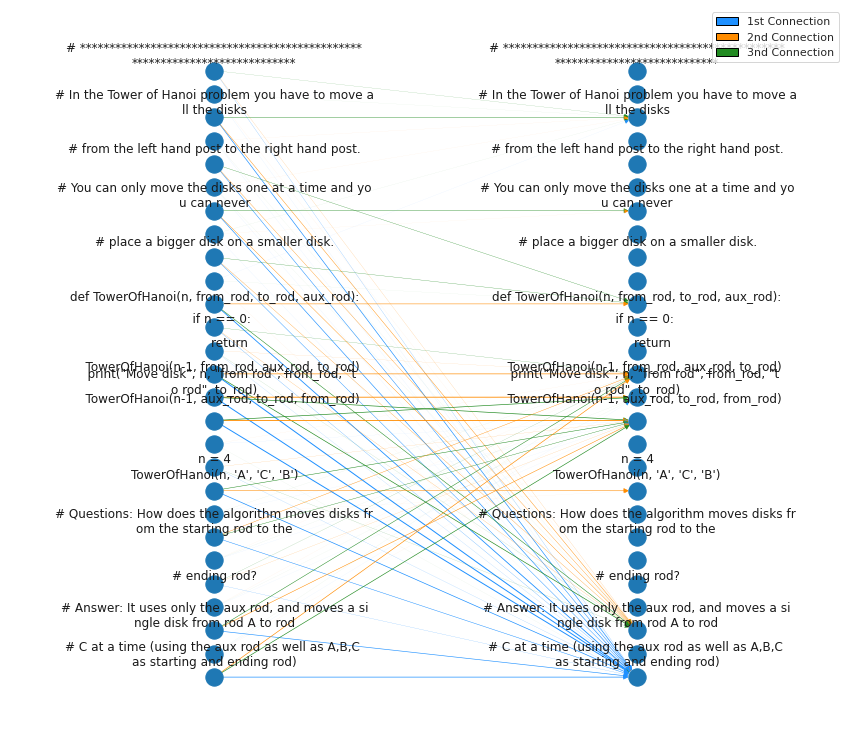

In [46]:
from attwizard.visualizer.matrix import visualize_followup_graph_side_by_side
visualize_followup_graph_side_by_side(
    adj_mat=line_level_att_tensor,
    from_seq=lines if len(lines) == line_level_att_tensor.shape[0] else lines[:-1],
    to_seq=lines if len(lines) == line_level_att_tensor.shape[0] else lines[:-1],
    #to_seq=metadata["tokens_all"][:-1],
    vertical_elements_spacing=(.5, .5),
    show_only_top_k=3
)

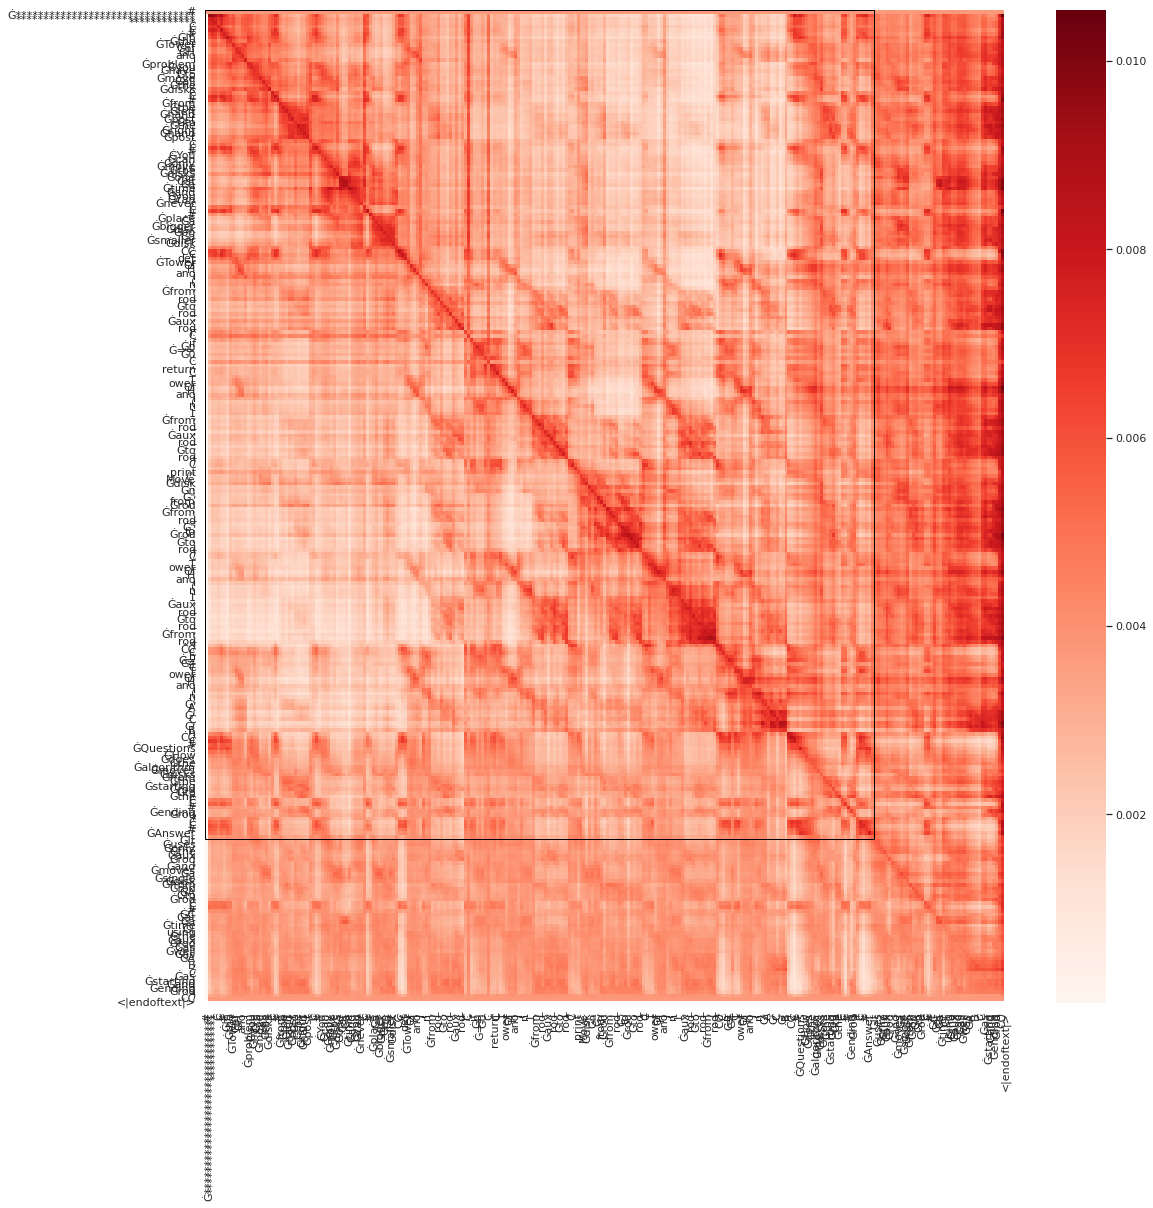

In [47]:
# Visualise those attention maps
heatmap_visualize(
    attention_matrix=att_matrix_3_processed,
    token_names=metadata["tokens_all"],
    n_input_tokens=len(metadata["tokens_prompt"])
) 
plt.gcf().set_size_inches(20, 20)

## Example 2: Tree Q3

In [48]:
FILE_NAME_TO_INSPECT = "tree_Q3.cpp_Salesforce_codegen-16B-multi"
FILE_PATH_ATT_TENSOR = os.path.join(EXP_FOLDER, FILE_NAME_TO_INSPECT + ".npy")
FILE_PATH_METADATA = os.path.join(EXP_FOLDER, FILE_NAME_TO_INSPECT + ".json")

att_tensor = np.load(FILE_PATH_ATT_TENSOR)
metadata = json.load(open(FILE_PATH_METADATA, 'r'))

# artificially add two useless dimensions
att_tensor = np.expand_dims(att_tensor, axis=0)
att_tensor = np.expand_dims(att_tensor, axis=2)

print(metadata.keys())
print(att_tensor.shape)
print(metadata["text_generated"])

dict_keys(['tokens_all', 'tokens_prompt', 'tokens_generated', 'text_generated', 'text_prompt', 'config_options', 'generation_time_seconds'])
(1, 34, 1, 24, 693, 693)
/***************************************************************************/

/*
# The following code deals with the creation of a tree data structure.
*/

#include <bits/stdc++.h>
using namespace std;

class node
{
public:
    int data;
    node *left;
    node *right;
};

node *newNode(int data)
{
    node *temp = new node();

    temp->data = data;
    temp->left = temp->right = NULL;

    return temp;
}

node *constructTreeUtil(int pre[], int post[], int *preIndex,
                        int l, int h, int size)
{
    if (*preIndex >= size || l > h)
        return NULL;

    node *root = newNode(pre[*preIndex]);
    ++*preIndex;

    if (l == h)
        return root;

    int i;
    for (i = l; i <= h; ++i)
        if (pre[*preIndex] == post[i])
            break;

    if (i <= h)
    {
        root->left = constructTr

In [49]:
att_matrix_3 = get_follow_up_attention_matrix_v2(att_tensor, normalise=True) # best so far
def normalize_matrix_by_lines(att_matrix):
    att_matrix[0,:] = 0.0000001
    att_matrix[:,0] = 0.0000001
    for i in range(att_matrix.shape[0]):
        att_matrix[i, :] = att_matrix[i, :] / att_matrix[i, :].sum()
    return att_matrix
# sum over the attention heads and normalize
att_matrix_3_processed = normalize_matrix_by_lines(att_matrix_3.sum(2))
# 12 min of computation for 600 tokens TODO optimize

In [50]:
# get the tokenization used by the model
codegen_tokenization_4_model = get_model_tokenization(
    raw_text=metadata["text_generated"],
    tokenizer="Salesforce/codegen-16B-multi",
    model_folder=MODEL_FOLDER,
    separate_new_lines_tokens=False,
)

# discard the last token because no-one is attending it
indices = np.array(
        [t['l'] - 1 for t in codegen_tokenization_4_model][:-1]
)

# reconstruct the lines corresponding to this tokenization
lines = []
unique_line_ids = list(set([t['l'] for t in codegen_tokenization_4_model]))
for i in unique_line_ids:
    new_line = "".join([
        t['t'] for t in codegen_tokenization_4_model 
        if t['l'] == i
    ])
    lines.append(new_line)

# condense the token -> token map to a line-> line matrix
line_level_att_tensor = att_matrix_3_processed

line_level_att_tensor = aggregate_dim_tokens_to_line(
    att_tensor=line_level_att_tensor,
    dim=0,
    line_indices=indices,
)
line_level_att_tensor = aggregate_dim_tokens_to_line(
    att_tensor=line_level_att_tensor,
    dim=1,
    line_indices=indices,
)
line_level_att_tensor.shape

torch.Size([94, 94])

(<Figure size 1080x3384 with 1 Axes>, <AxesSubplot:>)

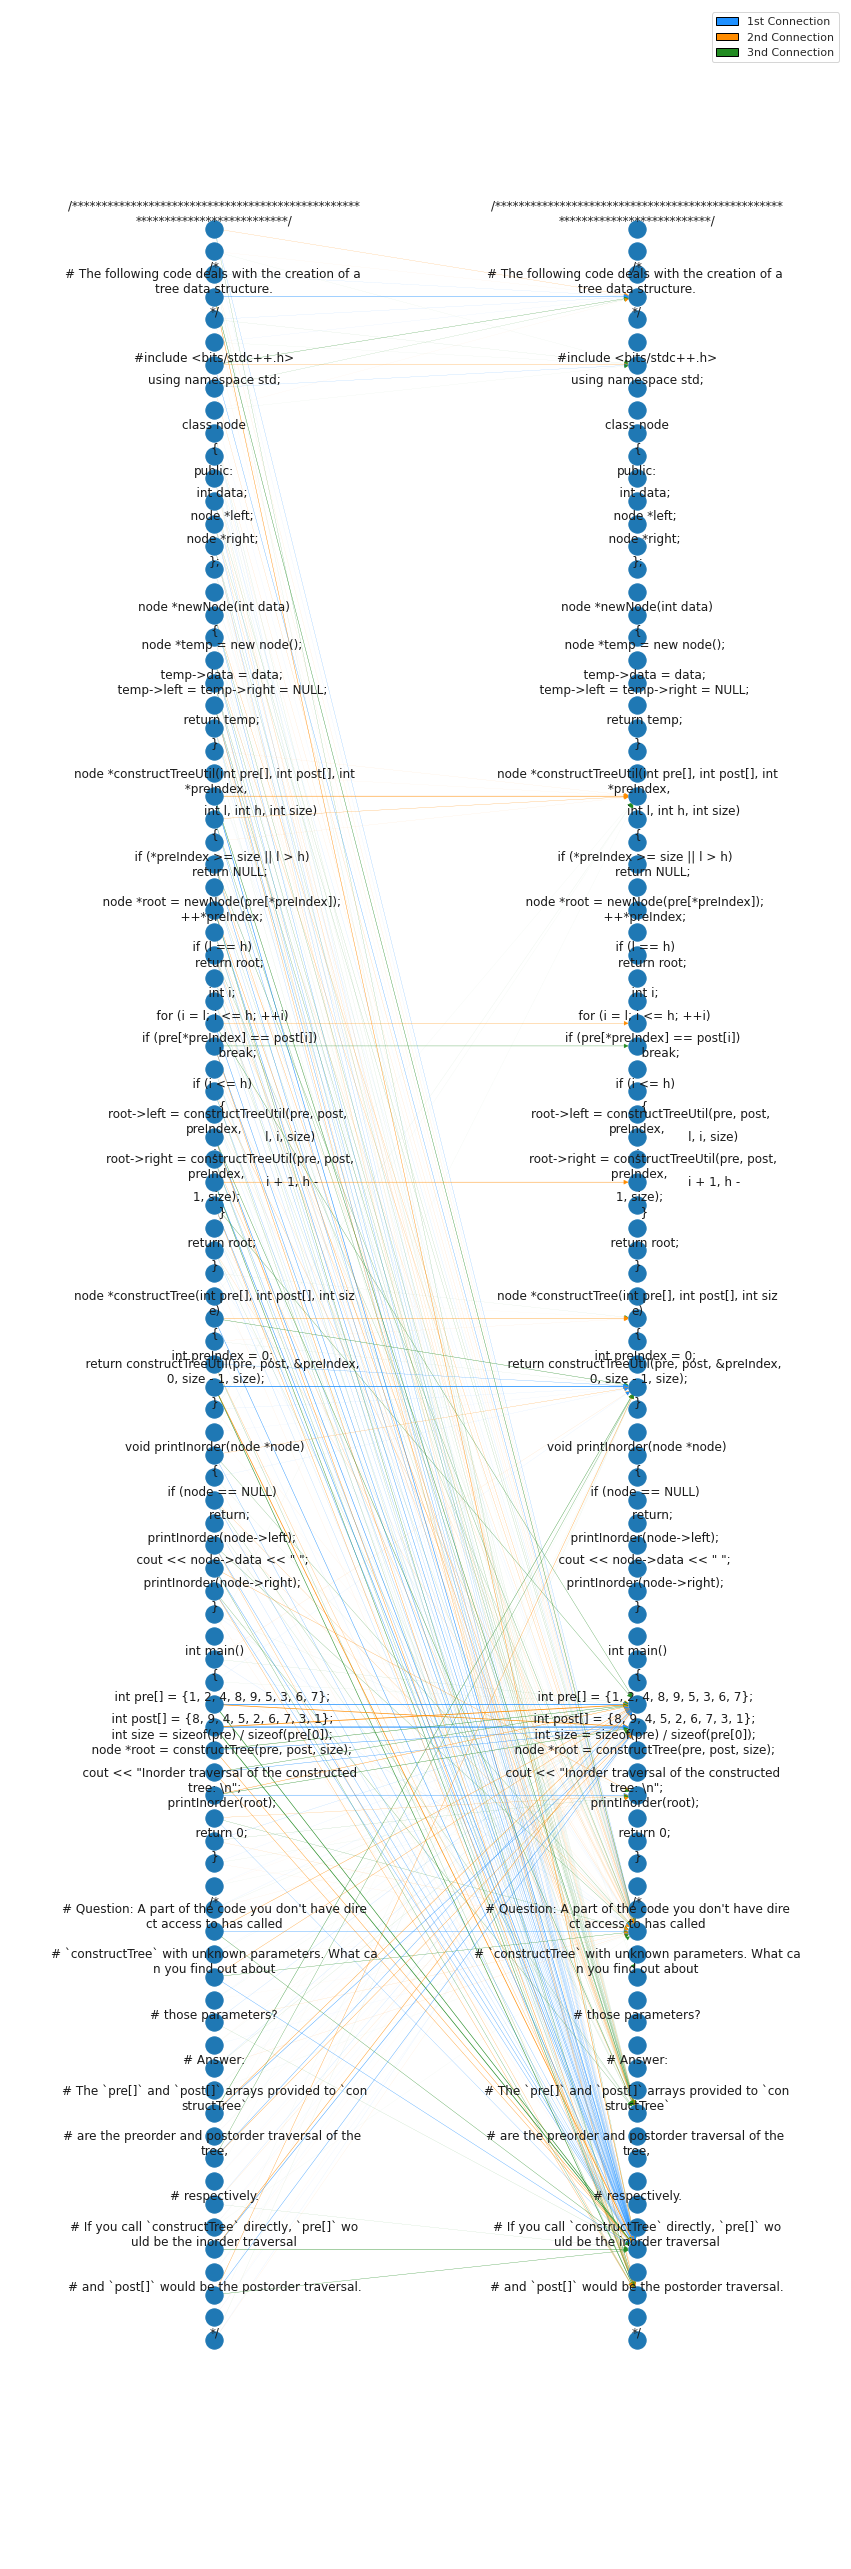

In [51]:
from attwizard.visualizer.matrix import visualize_followup_graph_side_by_side
visualize_followup_graph_side_by_side(
    adj_mat=line_level_att_tensor,
    from_seq=lines if len(lines) == line_level_att_tensor.shape[0] else lines[:-1],
    to_seq=lines if len(lines) == line_level_att_tensor.shape[0] else lines[:-1],
    #to_seq=metadata["tokens_all"][:-1],
    vertical_elements_spacing=(.5, .5),
    show_only_top_k=3
)

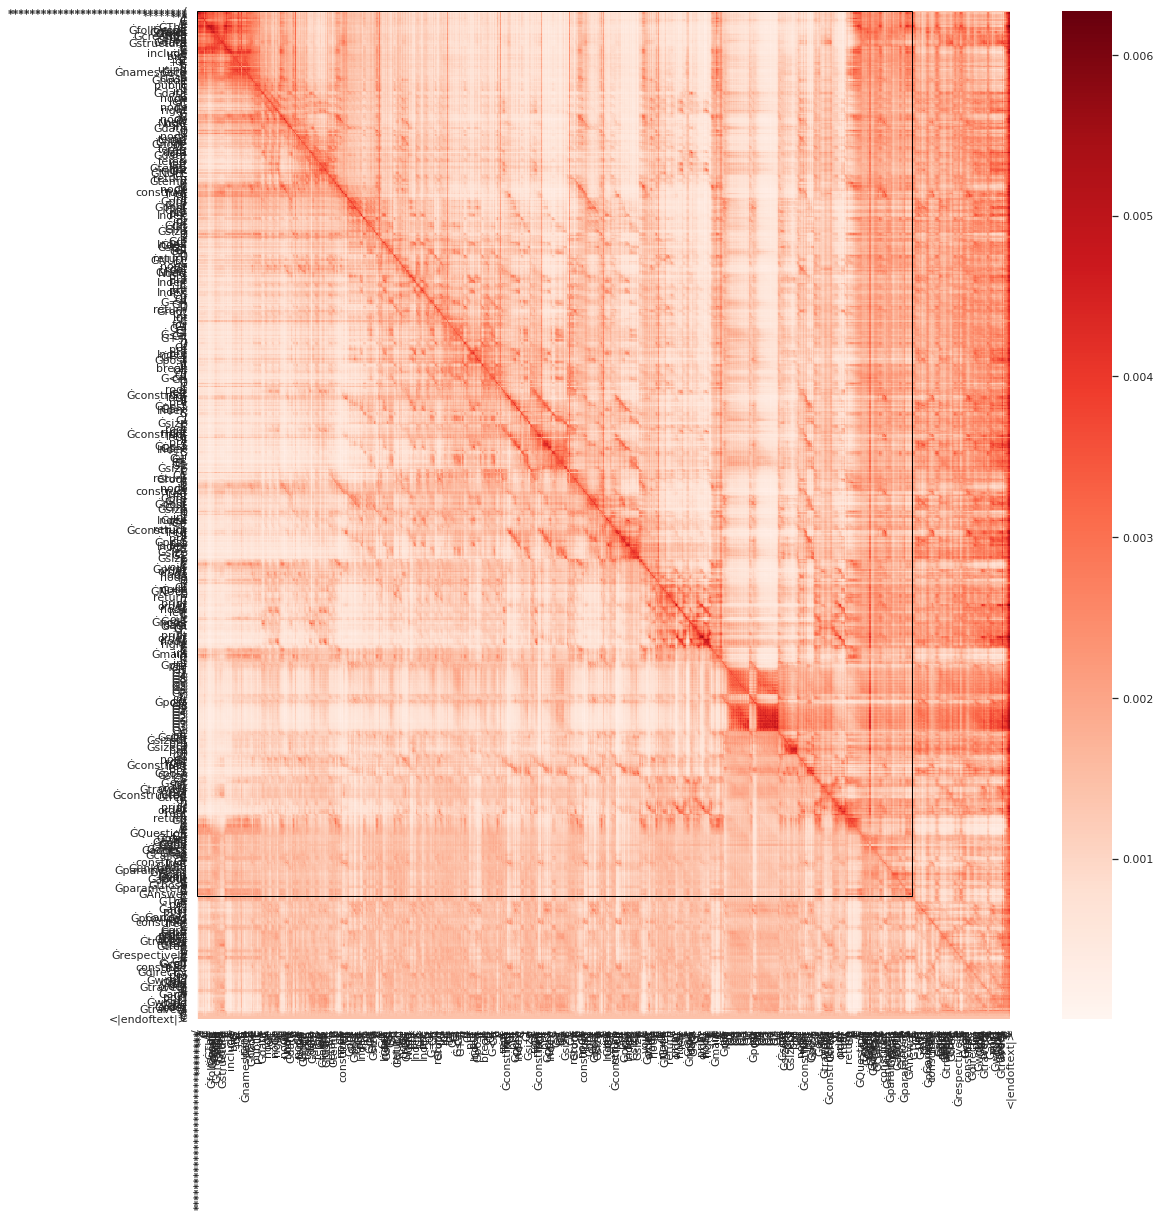

In [52]:
# Visualise those attention maps
heatmap_visualize(
    attention_matrix=att_matrix_3_processed,
    token_names=metadata["tokens_all"],
    n_input_tokens=len(metadata["tokens_prompt"])
) 
plt.gcf().set_size_inches(20, 20)

## Example 3: Nqueens Q2

In [53]:
FILE_NAME_TO_INSPECT = "Nqueens_Q2.cs_Salesforce_codegen-16B-multi"
FILE_PATH_ATT_TENSOR = os.path.join(EXP_FOLDER, FILE_NAME_TO_INSPECT + ".npy")
FILE_PATH_METADATA = os.path.join(EXP_FOLDER, FILE_NAME_TO_INSPECT + ".json")

att_tensor = np.load(FILE_PATH_ATT_TENSOR)
metadata = json.load(open(FILE_PATH_METADATA, 'r'))

# artificially add two useless dimensions
att_tensor = np.expand_dims(att_tensor, axis=0)
att_tensor = np.expand_dims(att_tensor, axis=2)

print(metadata.keys())
print(att_tensor.shape)
print(metadata["text_generated"])

dict_keys(['tokens_all', 'tokens_prompt', 'tokens_generated', 'text_generated', 'text_prompt', 'config_options', 'generation_time_seconds'])
(1, 34, 1, 24, 721, 721)
/*************************************************************************************************/


/*
# The n-queens puzzle is the problem of placing n queens on an n x n chessboard

# such that no two queens attack each other.

# The algorithm below solves the following problem.
*/


using System;

class GFG
{
    readonly int N = 4;

    void printSolution(int [,]board)
    {
        for (int i = 0; i < N; i++)
        {
            for (int j = 0; j < N; j++)
                Console.Write(" " + board[i, j]
                                + " ");
            Console.WriteLine();
        }
    }

    bool isSafe(int [,]board, int row, int col)
    {
        int i, j;

        for (i = 0; i < col; i++)
            if (board[row,i] == 1)
                return false;

        for (i = row, j = col; i >= 0 &&
            

In [54]:
att_matrix_3 = get_follow_up_attention_matrix_v2(att_tensor, normalise=True) # best so far
def normalize_matrix_by_lines(att_matrix):
    att_matrix[0,:] = 0.0000001
    att_matrix[:,0] = 0.0000001
    for i in range(att_matrix.shape[0]):
        att_matrix[i, :] = att_matrix[i, :] / att_matrix[i, :].sum()
    return att_matrix
# sum over the attention heads and normalize
att_matrix_3_processed = normalize_matrix_by_lines(att_matrix_3.sum(2))
# 

In [55]:
# get the tokenization used by the model
codegen_tokenization_4_model = get_model_tokenization(
    raw_text=metadata["text_generated"],
    tokenizer="Salesforce/codegen-16B-multi",
    model_folder=MODEL_FOLDER,
    separate_new_lines_tokens=False,
)

# discard the last token because no-one is attending it
indices = np.array(
        [t['l'] - 1 for t in codegen_tokenization_4_model][:-1]
)

# reconstruct the lines corresponding to this tokenization
lines = []
unique_line_ids = list(set([t['l'] for t in codegen_tokenization_4_model]))
for i in unique_line_ids:
    new_line = "".join([
        t['t'] for t in codegen_tokenization_4_model 
        if t['l'] == i
    ])
    lines.append(new_line)

# condense the token -> token map to a line-> line matrix
line_level_att_tensor = att_matrix_3_processed

line_level_att_tensor = aggregate_dim_tokens_to_line(
    att_tensor=line_level_att_tensor,
    dim=0,
    line_indices=indices,
)
line_level_att_tensor = aggregate_dim_tokens_to_line(
    att_tensor=line_level_att_tensor,
    dim=1,
    line_indices=indices,
)
line_level_att_tensor.shape

torch.Size([93, 93])

(<Figure size 1080x3348 with 1 Axes>, <AxesSubplot:>)

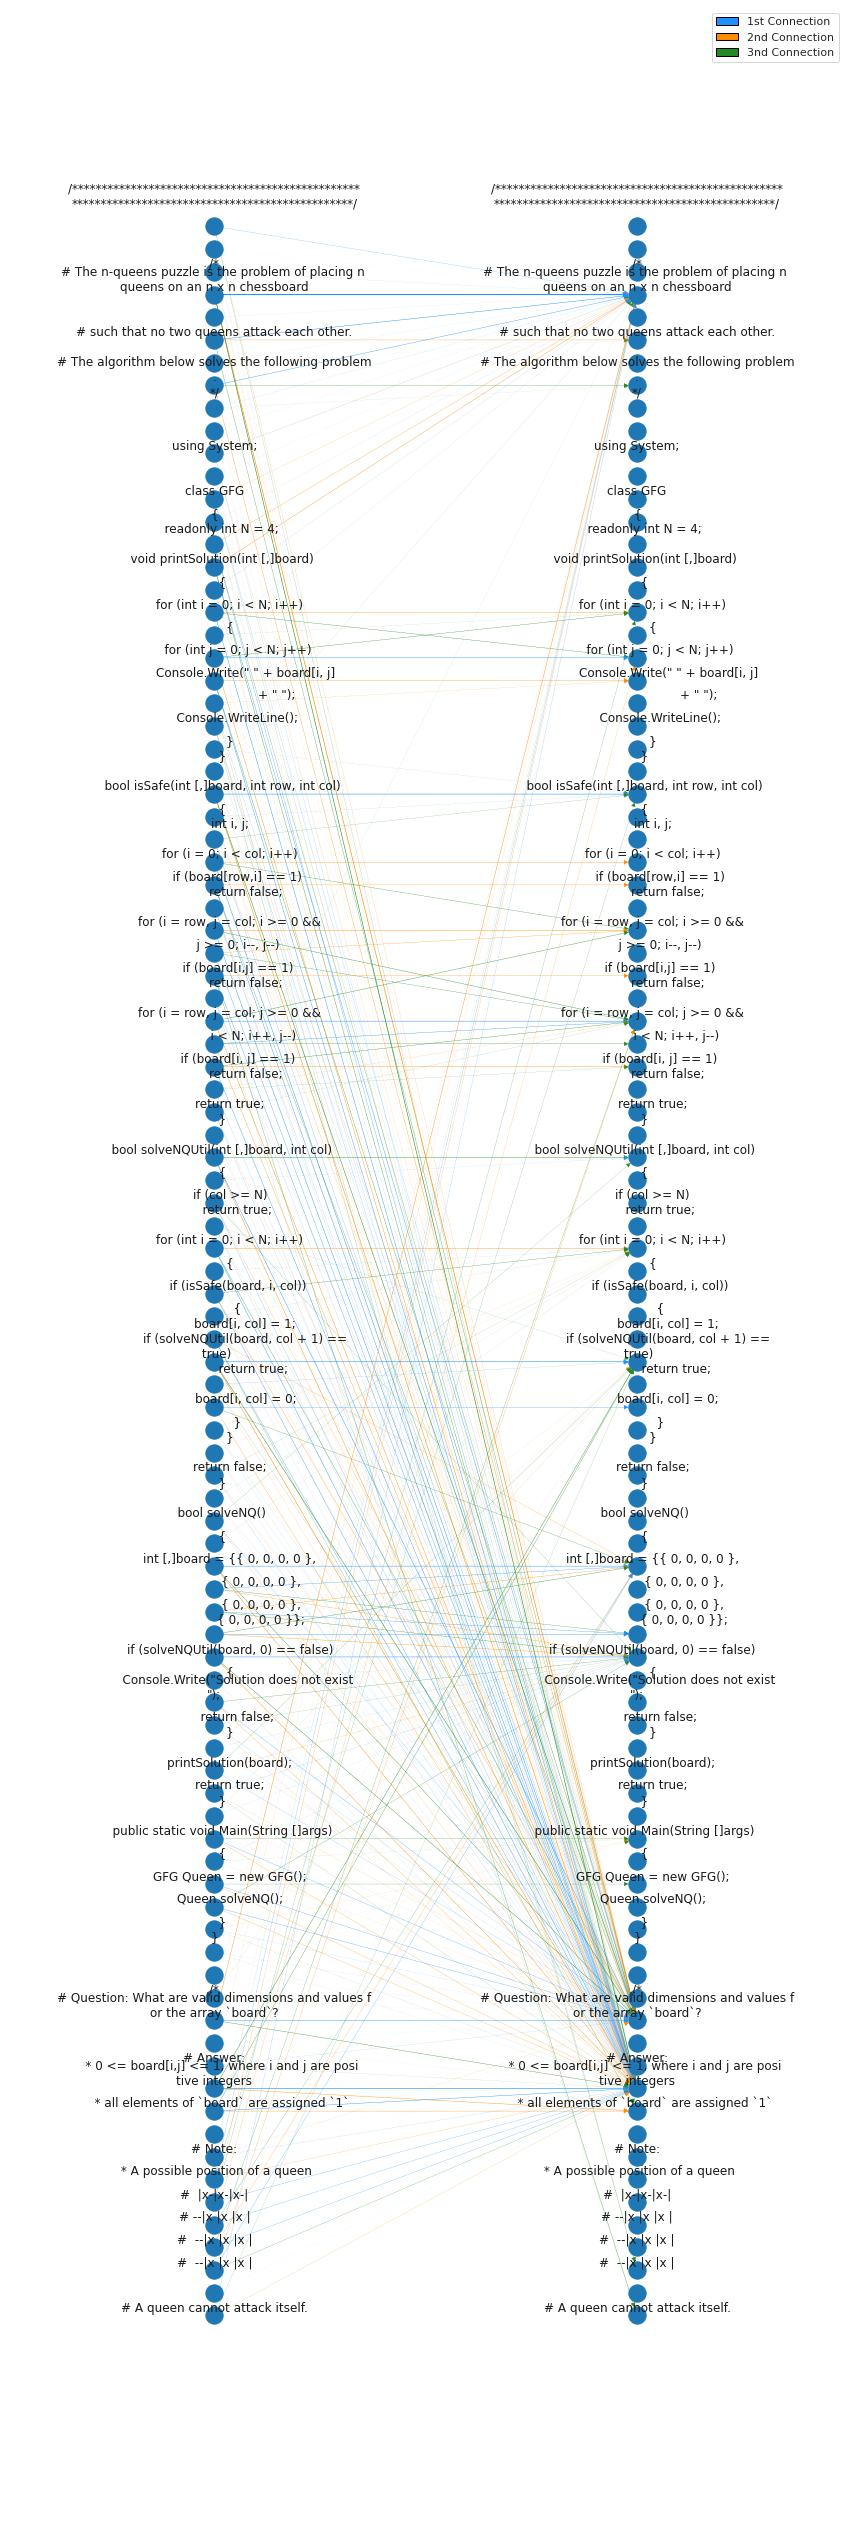

In [56]:
from attwizard.visualizer.matrix import visualize_followup_graph_side_by_side
visualize_followup_graph_side_by_side(
    adj_mat=line_level_att_tensor,
    from_seq=lines if len(lines) == line_level_att_tensor.shape[0] else lines[:-1],
    to_seq=lines if len(lines) == line_level_att_tensor.shape[0] else lines[:-1],
    #to_seq=metadata["tokens_all"][:-1],
    vertical_elements_spacing=(.5, .5),
    show_only_top_k=3
)

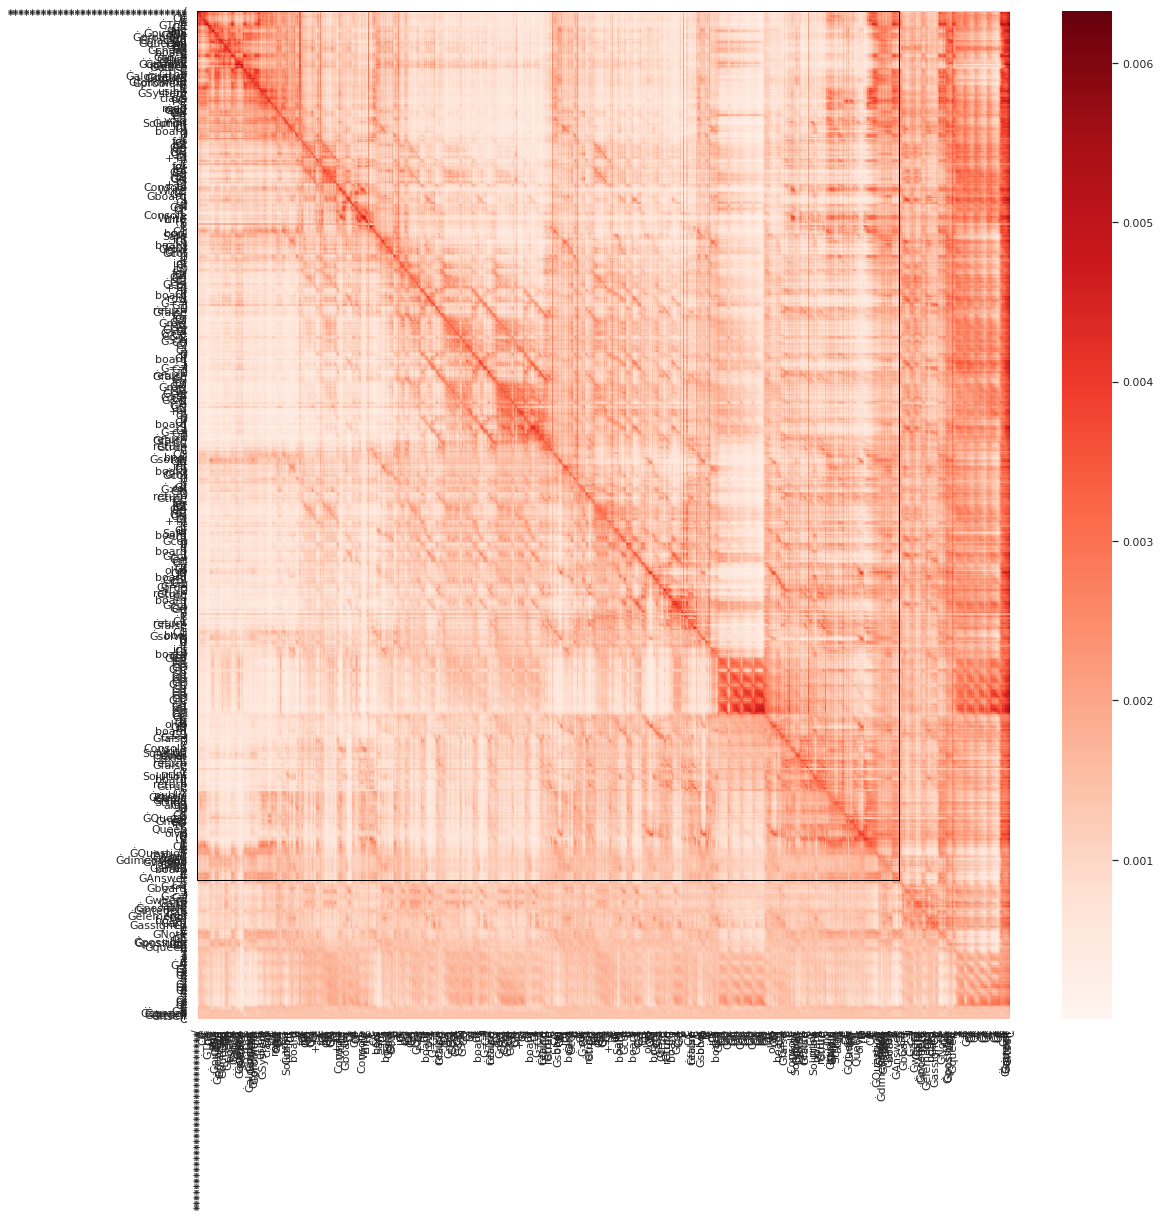

In [57]:
# Visualise those attention maps
heatmap_visualize(
    attention_matrix=att_matrix_3_processed,
    token_names=metadata["tokens_all"],
    n_input_tokens=len(metadata["tokens_prompt"])
) 
plt.gcf().set_size_inches(20, 20)